# Denoising Autoencoder

Los autocodificadores (autoencoders), son un tipo de red neuronal que consiste en una layer de entrada, generalmente una imagen, una o varias layers interiores y una layer de output del mismo tamaño que la entrada. La red neuronal puede entranarse con la misma imagen en entrada y salida, y el modelo aprenderá la estructura subyacente de la imagen. Puede pensarse que los autoencoders son una herramienta original para la compresión de datos, ya que la representación interior de la imagen es mas pequeña, pero en práctica no han demostrado ser muy efectivos.

Un denoising autoencoder es entrenado esta vez no con la misma imagen en entrada y salida, sino con la imagen corrupta en entrada y el TARGET, la imagen limpia, en salida. Así el Autoencoder aprenderá la representación importante y filtrará el ruido de las imágenes de test.

<img src="./Doc/autoencoder.png">

Primero utilizamos un ejemplo tomado de Kaggle de la competencia sobre limpieza de documentos:

https://www.kaggle.com/aakashnain/denoising-autoencoders-to-the-rescue

Luego, implementamos nuestro propio modelo, creando nuestro dataset de imagenes sucias a partir de un modelo original tomado de la página del Gobierno de Canarias. Para esto tomamos nuestro modelo original:
   - ./data/modeloA_originals
   
y les aplicamos varios niveles de blurring (borroso), thresholding (umbrales) y sharpening (afinamiento) con la herramienta:

http://www.fmwconcepts.com/imagemagick/textcleaner/index.php

Los datasets son los siguientes:
   - ./data/modeloA_train : dataset de entrenamiento con imagenes alteradas
   - ./data/modeloA_train_cleaned : dataset de entrenamiento con imagenes originales
   - ./data/modeloA_val : dataset de validación

Creados con los scripts createDataset.sh y textcleaner.

# 1. Autoencoder utilizando dataset de Kaggle

En esta parte romamos el ejemplo de Kaggle. Este consiste en un autoencoder con cuatro capas de CNN (Convolutional neural networks), entrenadas en 144 imagenes de textos sucios.

## 1.1 Importacion de librerias, datos y entrenamiento

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import os
from pathlib import Path
import glob
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from skimage.io import imread, imshow, imsave
from keras.preprocessing.image import load_img, array_to_img, img_to_array
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Input
from keras.optimizers import SGD, Adam, Adadelta, Adagrad
from keras import backend as K
from sklearn.model_selection import train_test_split
np.random.seed(111)
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "./data"]).decode("utf8"))
# Any results you write to the current directory are saved as output.

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Instructions for updating:
Use the retry module or similar alternatives.
Ivan
sampleSubmission.csv
sampleSubmission.csv.zip
test
test-0.01_background.png
test-0.01_clean.png
test-0.01_foreground_mask.png
test.zip
train
train_cleaned
train_cleaned.zip
train.zip



In [6]:
# Define paths in the fancy way, after all we have pathlib now. No more os.path.join...whatever!!
input_dir  = Path('./data/KaggleDenoising/')
train = input_dir / 'train'
train_cleaned = input_dir / 'train_cleaned'
test = input_dir / 'test'

('Total number of images in the training set: ', 144)
('Total number of cleaned images found: ', 144)
('Total number of samples in the test set: ', 72)


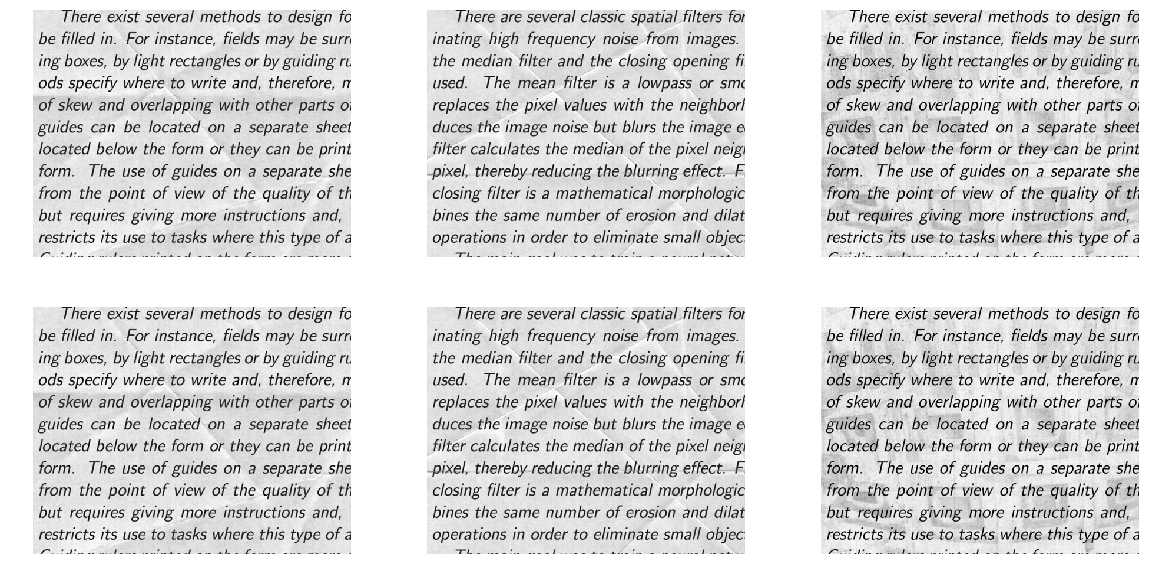

In [3]:
# The train directory comtaims png files. Let's get all the files and check a few samples
train_images = sorted(os.listdir(str(train)))
train_labels = sorted(os.listdir(str(train_cleaned)))
test_images = sorted(os.listdir(str(test)))
print("Total number of images in the training set: ", len(train_images))
print("Total number of cleaned images found: ", len(train_labels))
print("Total number of samples in the test set: ", len(test_images))

# Lets' plot a few samples
# First row will be raw data, second row will be the corresponding cleaned images
samples = train_images[:3] + train_labels[:3]

f, ax = plt.subplots(2, 3, figsize=(20,10))
for i, img in enumerate(samples):
    img = imread(str(train/img))
    ax[i//3, i%3].imshow(img, cmap='gray')
    ax[i//3, i%3].axis('off')
plt.show()  

In [4]:
# Lets' define our autoencoder now
def build_autoenocder():
    input_img = Input(shape=(420,540,1), name='image_input')
    
    #encoder 
    x = Conv2D(32, (3,3), activation='relu', padding='same', name='Conv1')(input_img)
    x = MaxPooling2D((2,2), padding='same', name='pool1')(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv2')(x)
    x = MaxPooling2D((2,2), padding='same', name='pool2')(x)
    
    #decoder
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv3')(x)
    x = UpSampling2D((2,2), name='upsample1')(x)
    x = Conv2D(32, (3,3), activation='relu', padding='same', name='Conv4')(x)
    x = UpSampling2D((2,2), name='upsample2')(x)
    x = Conv2D(1, (3,3), activation='sigmoid', padding='same', name='Conv5')(x)
    
    #model
    autoencoder = Model(inputs=input_img, outputs=x)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return autoencoder

In [5]:
autoencoder = build_autoenocder()
autoencoder.summary()

Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 420, 540, 1)       0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 420, 540, 32)      320       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 210, 270, 32)      0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 210, 270, 64)      18496     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 105, 135, 64)      0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 105, 135, 64)      36928     
_________________________________________________________________
ups

In [6]:
X = []
Y = []

for img in train_images:
    img = load_img(str(train / img), grayscale=True,target_size=(420,540))
    img = img_to_array(img).astype('float32')/255.
    X.append(img)

for img in train_labels:
    img = load_img(str(train_cleaned / img), grayscale=True,target_size=(420,540))
    img = img_to_array(img).astype('float32')/255.
    Y.append(img)


X = np.array(X)
Y = np.array(Y)

print("Size of X : ", X.shape)
print("Size of Y : ", Y.shape)

('Size of X : ', (144, 420, 540, 1))
('Size of Y : ', (144, 420, 540, 1))


In [7]:
# Split the dataset into training and validation. Always set the random state!!
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.1, random_state=111)
print("Total number of training samples: ", X_train.shape)
print("Total number of validation samples: ", X_valid.shape)

('Total number of training samples: ', (129, 420, 540, 1))
('Total number of validation samples: ', (15, 420, 540, 1))


In [8]:
# Train your model
autoencoder.fit(X_train, y_train, epochs=1000, batch_size=10, validation_data=(X_valid, y_valid))

Train on 129 samples, validate on 15 samples
Epoch 1/1000
129/129 [==============================] - 93s - loss: 0.4255 - val_loss: 0.3711
Epoch 2/1000
129/129 [==============================] - 96s - loss: 0.3532 - val_loss: 0.3484
Epoch 3/1000
129/129 [==============================] - 107s - loss: 0.3256 - val_loss: 0.3026
Epoch 4/1000
129/129 [==============================] - 105s - loss: 0.2693 - val_loss: 0.2550
Epoch 5/1000
129/129 [==============================] - 103s - loss: 0.2401 - val_loss: 0.2357
Epoch 6/1000
129/129 [==============================] - 105s - loss: 0.2225 - val_loss: 0.2202
Epoch 7/1000
129/129 [==============================] - 103s - loss: 0.2026 - val_loss: 0.2054
Epoch 8/1000
129/129 [==============================] - 101s - loss: 0.1887 - val_loss: 0.1961
Epoch 9/1000
129/129 [==============================] - 101s - loss: 0.1795 - val_loss: 0.1849
Epoch 10/1000
129/129 [==============================] - 107s - loss: 0.1714 - val_loss: 0.1796
Epoch 

129/129 [==============================] - 89s - loss: 0.1021 - val_loss: 0.1103
Epoch 172/1000
129/129 [==============================] - 89s - loss: 0.1021 - val_loss: 0.1105
Epoch 173/1000
129/129 [==============================] - 89s - loss: 0.1019 - val_loss: 0.1103
Epoch 174/1000
129/129 [==============================] - 89s - loss: 0.1018 - val_loss: 0.1103
Epoch 175/1000
129/129 [==============================] - 89s - loss: 0.1017 - val_loss: 0.1102
Epoch 176/1000
129/129 [==============================] - 89s - loss: 0.1019 - val_loss: 0.1103
Epoch 177/1000
129/129 [==============================] - 89s - loss: 0.1017 - val_loss: 0.1102
Epoch 178/1000
129/129 [==============================] - 89s - loss: 0.1018 - val_loss: 0.1101
Epoch 179/1000
129/129 [==============================] - 89s - loss: 0.1019 - val_loss: 0.1106
Epoch 180/1000
129/129 [==============================] - 89s - loss: 0.1018 - val_loss: 0.1100
Epoch 181/1000
129/129 [==============================]

129/129 [==============================] - 89s - loss: 0.0975 - val_loss: 0.1056
Epoch 342/1000
129/129 [==============================] - 89s - loss: 0.0975 - val_loss: 0.1056
Epoch 343/1000
129/129 [==============================] - 89s - loss: 0.0975 - val_loss: 0.1056
Epoch 344/1000
129/129 [==============================] - 89s - loss: 0.0975 - val_loss: 0.1056
Epoch 345/1000
129/129 [==============================] - 90s - loss: 0.0974 - val_loss: 0.1057
Epoch 346/1000
129/129 [==============================] - 89s - loss: 0.0975 - val_loss: 0.1055
Epoch 347/1000
129/129 [==============================] - 89s - loss: 0.0974 - val_loss: 0.1056
Epoch 348/1000
129/129 [==============================] - 89s - loss: 0.0976 - val_loss: 0.1056
Epoch 349/1000
129/129 [==============================] - 89s - loss: 0.0974 - val_loss: 0.1055
Epoch 350/1000
129/129 [==============================] - 89s - loss: 0.0974 - val_loss: 0.1057
Epoch 351/1000
129/129 [==============================]

129/129 [==============================] - 89s - loss: 0.0955 - val_loss: 0.1036
Epoch 512/1000
129/129 [==============================] - 90s - loss: 0.0955 - val_loss: 0.1036
Epoch 513/1000
129/129 [==============================] - 89s - loss: 0.0954 - val_loss: 0.1035
Epoch 514/1000
129/129 [==============================] - 89s - loss: 0.0956 - val_loss: 0.1037
Epoch 515/1000
129/129 [==============================] - 89s - loss: 0.0955 - val_loss: 0.1035
Epoch 516/1000
129/129 [==============================] - 89s - loss: 0.0954 - val_loss: 0.1035
Epoch 517/1000
129/129 [==============================] - 89s - loss: 0.0954 - val_loss: 0.1035
Epoch 518/1000
129/129 [==============================] - 90s - loss: 0.0955 - val_loss: 0.1034
Epoch 519/1000
129/129 [==============================] - 89s - loss: 0.0955 - val_loss: 0.1035
Epoch 520/1000
129/129 [==============================] - 89s - loss: 0.0955 - val_loss: 0.1035
Epoch 521/1000
129/129 [==============================]

129/129 [==============================] - 91s - loss: 0.0945 - val_loss: 0.1024
Epoch 682/1000
129/129 [==============================] - 94s - loss: 0.0945 - val_loss: 0.1024
Epoch 683/1000
129/129 [==============================] - 96s - loss: 0.0945 - val_loss: 0.1023
Epoch 684/1000
129/129 [==============================] - 94s - loss: 0.0944 - val_loss: 0.1024
Epoch 685/1000
129/129 [==============================] - 95s - loss: 0.0944 - val_loss: 0.1024
Epoch 686/1000
129/129 [==============================] - 95s - loss: 0.0944 - val_loss: 0.1023
Epoch 687/1000
129/129 [==============================] - 96s - loss: 0.0943 - val_loss: 0.1023
Epoch 688/1000
129/129 [==============================] - 95s - loss: 0.0944 - val_loss: 0.1023
Epoch 689/1000
129/129 [==============================] - 105s - loss: 0.0944 - val_loss: 0.1023
Epoch 690/1000
129/129 [==============================] - 96s - loss: 0.0944 - val_loss: 0.1023
Epoch 691/1000
129/129 [==============================

129/129 [==============================] - 94s - loss: 0.0938 - val_loss: 0.1016
Epoch 852/1000
129/129 [==============================] - 94s - loss: 0.0938 - val_loss: 0.1019
Epoch 853/1000
129/129 [==============================] - 95s - loss: 0.0939 - val_loss: 0.1018
Epoch 854/1000
129/129 [==============================] - 93s - loss: 0.0938 - val_loss: 0.1016
Epoch 855/1000
129/129 [==============================] - 94s - loss: 0.0937 - val_loss: 0.1016
Epoch 856/1000
129/129 [==============================] - 94s - loss: 0.0938 - val_loss: 0.1018
Epoch 857/1000
129/129 [==============================] - 96s - loss: 0.0937 - val_loss: 0.1018
Epoch 858/1000
129/129 [==============================] - 94s - loss: 0.0937 - val_loss: 0.1017
Epoch 859/1000
129/129 [==============================] - 95s - loss: 0.0937 - val_loss: 0.1016
Epoch 860/1000
129/129 [==============================] - 94s - loss: 0.0939 - val_loss: 0.1019
Epoch 861/1000
129/129 [==============================]

Aplicamos el modelo en una imagen de test:

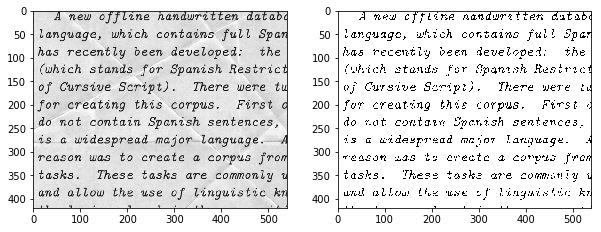

In [11]:
# Let's test our model on a sample test image
sample_test = load_img(str(test/ test_images[10]), grayscale=True, target_size=(420,540))
sample_test = img_to_array(sample_test)
sample_test_img = sample_test.astype('float32')/255.
sample_test_img = np.expand_dims(sample_test, axis=0)

# Get the predition
predicted_label = np.squeeze(autoencoder.predict(sample_test_img))

f, ax = plt.subplots(1,2, figsize=(10,8))
ax[0].imshow(np.squeeze(sample_test), cmap='gray')
ax[1].imshow(np.squeeze(predicted_label.astype('int8')), cmap='gray')
plt.show()

In [35]:
sample_test_img.shape

(1, 420, 540, 1)

In [123]:
sample_test_img[0][0][1]

array([229.], dtype=float32)

In [12]:
# serialize model to JSON
model_json = autoencoder.to_json()
with open("autoencoder_1000epochs.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
autoencoder.save_weights("autoencoder_1000epochs.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
# later...
 
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = loaded_model.evaluate(X, Y, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

## 1.2 Aplicación a nuestra imagen de test

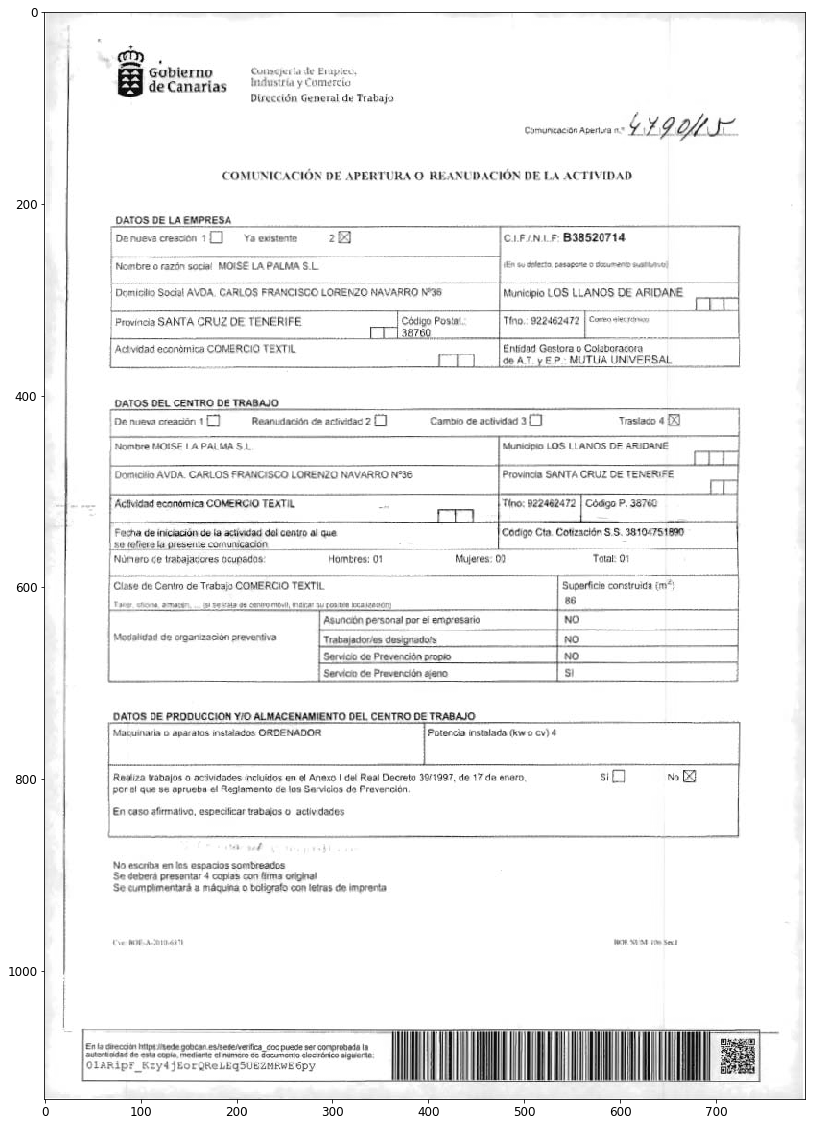

(1134, 793, 1)

In [159]:
# Let's test our model on a sample test image
img_test = load_img("./data/Arte/test.png", grayscale=True)
img_test = img_to_array(img_test)
img_test_img = img_test.astype('float32')/255.
img_test_img = np.expand_dims(img_test, axis=0)

plt.figure(figsize=(20,20))
plt.title("{}x{}".format(img_test_img.shape[1], img_test_img.shape[0]))
plt.imshow(np.squeeze(img_test_img), cmap='gray')
plt.axis("off")
plt.show()

img_test.shape

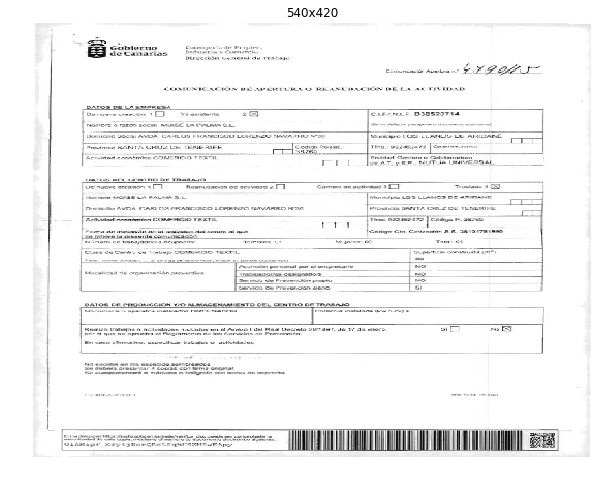

(420, 540, 1)

In [13]:
# Let's test our model on a sample test image
img_test = load_img("./data/Arte/test.png", grayscale=True, target_size=(420,540))
img_test = img_to_array(img_test)
img_test_img = img_test.astype('float32')/255.
img_test_img = np.expand_dims(img_test, axis=0)

plt.figure(figsize=(10,10))
plt.title("{}x{}".format(img_test.shape[1], img_test.shape[0]))
plt.imshow(np.squeeze(img_test), cmap='gray')
plt.axis("off")
plt.show()

img_test.shape

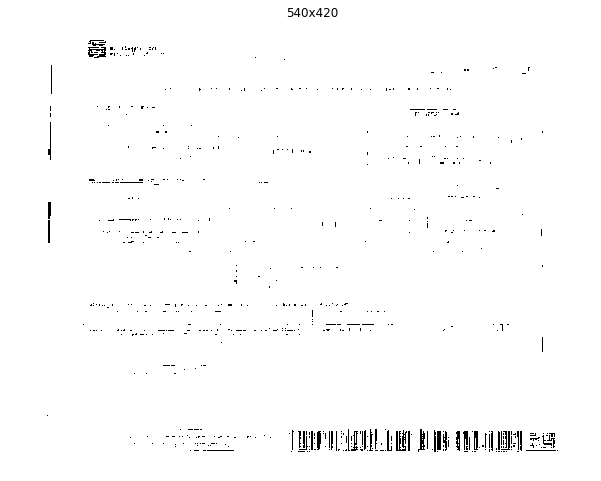

In [14]:
# Get the predition
predicted_label = np.squeeze(autoencoder.predict(img_test_img))

plt.figure(figsize=(10,10))
plt.title("{}x{}".format(np.squeeze(predicted_label.astype('int8')).shape[1], np.squeeze(predicted_label.astype('int8')).shape[0]))
plt.imshow(np.squeeze(predicted_label.astype('int8')), cmap='gray')
plt.axis("off")
plt.show()

Observamos una imagen que ha perdido toda la información, aun si la estructura esta conservada. Observamos que tenemos que adapar el tamaño de nuestro documento al tamaño de las imagenes utilizadas para entrenar el autoencoder. Haría falta entranar mejor el modelo, con mas datos, mas profundo, mas tiempo... Pasemos a nuestro propio entrenamiento.

# 2. Autoencoder con datos propios

En esta parte entrenamos nuestro propio autoencoder con los datos creados.

## 2.1 Importacion de librerías, datos y entrenamiento

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import os
from pathlib import Path
import glob
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from skimage.io import imread, imshow, imsave
from keras.preprocessing.image import load_img, array_to_img, img_to_array
from keras.models import Sequential, Model, model_from_json 
from keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Input
from keras.optimizers import SGD, Adam, Adadelta, Adagrad
from keras import backend as K
from sklearn.model_selection import train_test_split
np.random.seed(111)
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "./data"]).decode("utf8"))
# Any results you write to the current directory are saved as output.

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Instructions for updating:
Use the retry module or similar alternatives.
Arte
KaggleDenoising
modeloA_originals
modeloA_train
modeloA_train_cleaned
modeloA_val



In [7]:
# Define paths in the fancy way, after all we have pathlib now. No more os.path.join...whatever!!
input_dir  = Path('./data/')
train = input_dir / 'modeloA_train'
train_cleaned = input_dir / 'modeloA_train_cleaned'

('Total number of images in the training set: ', 80)
('Total number of cleaned images found: ', 80)


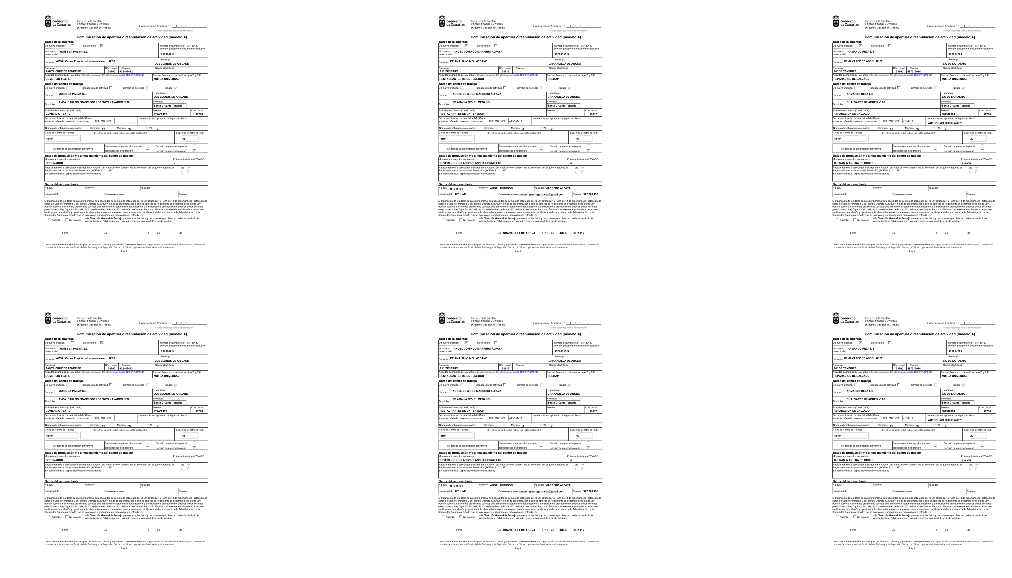

In [9]:
# The train directory comtaims png files. Let's get all the files and check a few samples
train_images = sorted(os.listdir(str(train)))
train_labels = sorted(os.listdir(str(train_cleaned)))
print("Total number of images in the training set: ", len(train_images))
print("Total number of cleaned images found: ", len(train_labels))

# Lets' plot a few samples
# First row will be raw data, second row will be the corresponding cleaned images
samples = train_images[:3] + train_labels[:3]

f, ax = plt.subplots(2, 3, figsize=(20,10))
for i, img in enumerate(samples):
    img = imread(str(train/img))
    ax[i//3, i%3].imshow(img, cmap='gray')
    ax[i//3, i%3].axis('off')
plt.show()  

In [4]:
## Check shapes of images
for im in train_images:
    image = load_img("./data/modeloA_train/"+im, grayscale=True, target_size=(1756,1240))
    img_train = img_to_array(image)
    img_train_img = img_train.astype('float32')/255.
    img_train_img = np.expand_dims(img_train, axis=0)
    print("{}x{}".format(img_train_img.shape[2], img_train_img.shape[1]))

1240x1756
1240x1756
1240x1756
1240x1756
1240x1756
1240x1756
1240x1756
1240x1756
1240x1756
1240x1756
1240x1756
1240x1756
1240x1756
1240x1756
1240x1756
1240x1756
1240x1756
1240x1756
1240x1756
1240x1756
1240x1756
1240x1756
1240x1756
1240x1756
1240x1756
1240x1756
1240x1756
1240x1756
1240x1756
1240x1756
1240x1756
1240x1756
1240x1756
1240x1756
1240x1756
1240x1756
1240x1756
1240x1756
1240x1756
1240x1756
1240x1756
1240x1756
1240x1756
1240x1756
1240x1756
1240x1756
1240x1756
1240x1756
1240x1756
1240x1756
1240x1756
1240x1756
1240x1756
1240x1756
1240x1756
1240x1756
1240x1756
1240x1756
1240x1756
1240x1756
1240x1756
1240x1756
1240x1756
1240x1756
1240x1756
1240x1756
1240x1756
1240x1756
1240x1756
1240x1756
1240x1756
1240x1756
1240x1756
1240x1756
1240x1756
1240x1756
1240x1756
1240x1756
1240x1756
1240x1756


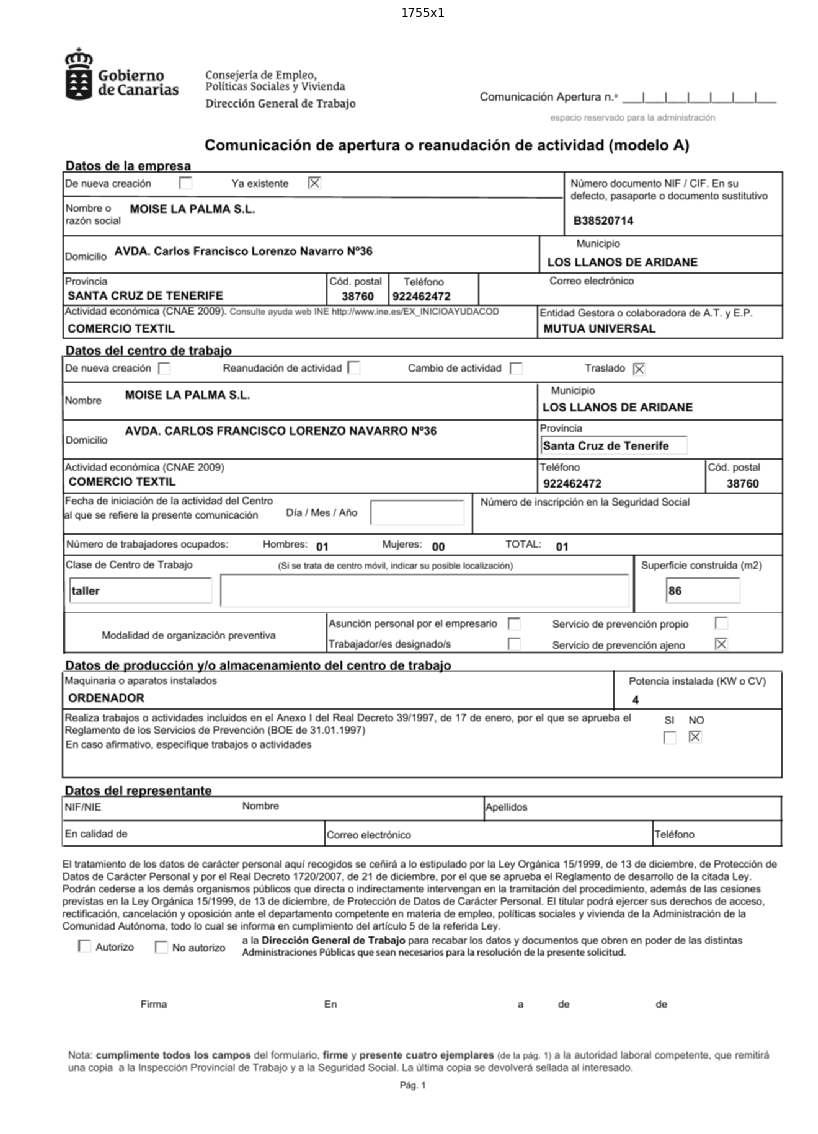

(1755, 1240, 1)

In [5]:
# Let's test our model on a sample test image
img_test = load_img("./data/modeloA_train/out_modeloA_blur1x1_0.png", grayscale=True)
img_test = img_to_array(img_test)
img_test_img = img_test.astype('float32')/255.
img_test_img = np.expand_dims(img_test, axis=0)

plt.figure(figsize=(20,20))
plt.title("{}x{}".format(img_test_img.shape[1], img_test_img.shape[0]))
plt.imshow(np.squeeze(img_test_img), cmap='gray')
plt.axis("off")
plt.show()

img_test.shape

## 2.2 Denoising Autoencoder

Probamos varias estructuras de Autoencoder utilizando la librería Keras:

In [9]:
from layers_tied import Convolution2D_tied

# Lets' define our autoencoder now
def build_autoencoder():
    input_img = Input(shape=(1760,1240,1), name='image_input')
    
    #encoder 
    x = Conv2D(32, (3,3), activation='relu', padding='same', name='Conv1')(input_img)
    x = MaxPooling2D((2,2), padding='same', name='pool1')(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv2')(x)
    x = MaxPooling2D((2,2), padding='same', name='pool2')(x)
    
    #decoder
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv3')(x)
    x = UpSampling2D((2,2), name='upsample1')(x)
    x = Conv2D(32, (3,3), activation='relu', padding='same', name='Conv4')(x)
    x = UpSampling2D((2,2), name='upsample2')(x)
    x = Conv2D(1, (3,3), activation='sigmoid', padding='same', name='Conv5')(x)
    
    #model
    autoencoder = Model(inputs=input_img, outputs=x)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return autoencoder

# Lets' define our autoencoder now
def build_autoencoder_v3():
    input_img = Input(shape=(1760,1240,1), name='image_input')
    
    #encoder 
    x = Conv2D(32, (3,3), activation='relu', padding='same', name='Conv1')(input_img)
    x = MaxPooling2D((2,2), padding='same', name='pool1')(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv2')(x)
    x = MaxPooling2D((2,2), padding='same', name='pool2')(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv3')(x)
    x = MaxPooling2D((2,2), padding='same', name='pool3')(x)
    
    #decoder
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv4')(x)
    x = UpSampling2D((2,2), name='upsample1')(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv5')(x)
    x = UpSampling2D((2,2), name='upsample2')(x)
    x = Conv2D(32, (3,3), activation='relu', padding='same', name='Conv6')(x)
    x = UpSampling2D((2,2), name='upsample3')(x)
    x = Conv2D(1, (3,3), activation='sigmoid', padding='same', name='Conv7')(x)
    
    #model
    autoencoder = Model(inputs=input_img, outputs=x)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return autoencoder

def build_autoencoder_Dense_v4():
    input_img = Input(shape=(1760,1240,1), name='image_input')
    
    #encoder 
    fc1 = Dense(32, activation='relu', name='fc1')(input_img)
    maxpool1 = MaxPooling2D((2,2), padding='same', name='pool1')(fc1)
    fc2 = Dense(64, activation='relu', name='fc2')(maxpool1)
    maxpool2 = MaxPooling2D((2,2), padding='same', name='pool2')(fc2)

    
    #decoder
    fc3 = Dense(64, activation='relu', name='fc3')(maxpool2)
    up1 = UpSampling2D((2,2), name='upsample1')(fc3)
    fc4 = Dense(32, activation='relu', name='fc4')(up1)
    up2 = UpSampling2D((2,2), name='upsample2')(fc4)
    fc5 = Dense(1, activation='sigmoid', name='fc5')(up2)
    
    #model
    autoencoder = Model(inputs=input_img, outputs=fc5)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    
    return autoencoder

In [10]:
autoencoder = build_autoencoder()
#autoencoder = build_autoencoder_v3()
#autoencoder = build_autoencoder_Dense_v4()
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 1760, 1240, 1)     0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 1760, 1240, 32)    320       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 880, 620, 32)      0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 880, 620, 64)      18496     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 440, 310, 64)      0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 440, 310, 64)      36928     
_________________________________________________________________
upsample1 (UpSampling2D)     (None, 880, 620, 64)      0         
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
image_input (InputLayer)     (None, 1760, 1240, 1)     0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 1760, 1240, 32)    320       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 880, 620, 32)      0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 880, 620, 64)      18496     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 440, 310, 64)      0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 440, 310, 64)      36928     
_________________________________________________________________
pool3 (MaxPooling2D)         (None, 220, 155, 64)      0         
_________________________________________________________________
Conv4 (Conv2D)               (None, 220, 155, 64)      36928     
_________________________________________________________________
upsample1 (UpSampling2D)     (None, 440, 310, 64)      0         
_________________________________________________________________
Conv5 (Conv2D)               (None, 440, 310, 64)      36928     
_________________________________________________________________
upsample2 (UpSampling2D)     (None, 880, 620, 64)      0         
_________________________________________________________________
Conv6 (Conv2D)               (None, 880, 620, 32)      18464     
_________________________________________________________________
upsample3 (UpSampling2D)     (None, 1760, 1240, 32)    0         
_________________________________________________________________
Conv7 (Conv2D)               (None, 1760, 1240, 1)     289       
=================================================================
Total params: 148,353
Trainable params: 148,353
Non-trainable params: 0
_________________________________________________________________


In [12]:
X = []
Y = []

for img in train_images:
    img = load_img(str(train / img), grayscale=True,target_size=(1760,1240))
    img = img_to_array(img).astype('float32')/255.
    X.append(img)

for img in train_labels:
    img = load_img(str(train_cleaned / img), grayscale=True,target_size=(1760,1240))
    img = img_to_array(img).astype('float32')/255.
    Y.append(img)


X = np.array(X)
Y = np.array(Y)

print("Size of X : ", X.shape)
print("Size of Y : ", Y.shape)

('Size of X : ', (80, 1760, 1240, 1))
('Size of Y : ', (80, 1760, 1240, 1))


In [13]:
# Split the dataset into training and validation. Always set the random state!!
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.1, random_state=111)
print("Total number of training samples: ", X_train.shape)
print("Total number of validation samples: ", X_valid.shape)

('Total number of training samples: ', (72, 1760, 1240, 1))
('Total number of validation samples: ', (8, 1760, 1240, 1))


In [ ]:
# Train your model
autoencoder.fit(X_train, y_train, epochs=500, batch_size=1, validation_data=(X_valid, y_valid))

Train on 72 samples, validate on 8 samples
Epoch 1/500
72/72 [==============================] - 522s - loss: 0.2549 - val_loss: 0.1792
Epoch 2/500
72/72 [==============================] - 523s - loss: 0.1645 - val_loss: 0.1466
Epoch 3/500
72/72 [==============================] - 542s - loss: 0.1463 - val_loss: 0.1367
Epoch 4/500
72/72 [==============================] - 575s - loss: 0.1397 - val_loss: 0.1338
Epoch 5/500
72/72 [==============================] - 560s - loss: 0.1297 - val_loss: 0.1204
Epoch 6/500
72/72 [==============================] - 540s - loss: 0.1209 - val_loss: 0.1222
Epoch 7/500
72/72 [==============================] - 548s - loss: 0.1136 - val_loss: 0.1073
Epoch 8/500
72/72 [==============================] - 553s - loss: 0.1100 - val_loss: 0.1301
Epoch 9/500
72/72 [==============================] - 595s - loss: 0.1081 - val_loss: 0.1040
Epoch 10/500
58/72 [=======================>......] - ETA: 140s - loss: 0.103 - ETA: 132s - loss: 0.1033

Train on 72 samples, validate on 8 samples
Epoch 1/20
72/72 [==============================] - 529s - loss: 0.2442 - val_loss: 0.1610
Epoch 2/20
72/72 [==============================] - 515s - loss: 0.1582 - val_loss: 0.1415
Epoch 3/20
72/72 [==============================] - 522s - loss: 0.1439 - val_loss: 0.1269
Epoch 4/20
72/72 [==============================] - 545s - loss: 0.1258 - val_loss: 0.1212
Epoch 5/20
72/72 [==============================] - 533s - loss: 0.1220 - val_loss: 0.1112
Epoch 6/20
72/72 [==============================] - 531s - loss: 0.1124 - val_loss: 0.1098
Epoch 7/20
72/72 [==============================] - 537s - loss: 0.1081 - val_loss: 0.1020
Epoch 8/20
72/72 [==============================] - 540s - loss: 0.1060 - val_loss: 0.0967
Epoch 9/20
72/72 [==============================] - 534s - loss: 0.1013 - val_loss: 0.0944
Epoch 10/20
72/72 [==============================] - 524s - loss: 0.0982 - val_loss: 0.0924
Epoch 11/20
72/72 [==============================] - 531s - loss: 0.0982 - val_loss: 0.0916
Epoch 12/20
72/72 [==============================] - 527s - loss: 0.0968 - val_loss: 0.0899
Epoch 13/20
72/72 [==============================] - 522s - loss: 0.0983 - val_loss: 0.0946
Epoch 14/20
72/72 [==============================] - 519s - loss: 0.0946 - val_loss: 0.0894
Epoch 15/20
72/72 [==============================] - 522s - loss: 0.0927 - val_loss: 0.0913
Epoch 16/20
72/72 [==============================] - 530s - loss: 0.0951 - val_loss: 0.0912
Epoch 17/20
72/72 [==============================] - 562s - loss: 0.0919 - val_loss: 0.0953
Epoch 18/20
72/72 [==============================] - 550s - loss: 0.0923 - val_loss: 0.0855
Epoch 19/20
72/72 [==============================] - 555s - loss: 0.0916 - val_loss: 0.0869
Epoch 20/20
72/72 [==============================] - 534s - loss: 0.0934 - val_loss: 0.0916

<keras.callbacks.History at 0x7fd45c4bcad0>


v4:
Train on 72 samples, validate on 8 samples
Epoch 1/5
72/72 [==============================] - 213s - loss: 0.3772 - val_loss: 0.2489
Epoch 2/5
72/72 [==============================] - 215s - loss: 0.2341 - val_loss: 0.1994
Epoch 3/5
72/72 [==============================] - 208s - loss: 0.1779 - val_loss: 0.1692
Epoch 4/5
72/72 [==============================] - 219s - loss: 0.1713 - val_loss: 0.1673
Epoch 5/5
72/72 [==============================] - 221s - loss: 0.1695 - val_loss: 0.1663


## 2.3 Guardar y recuperar los modelos

Guardamos nuestro modelos entrenados en ./models

In [72]:
# serialize model to JSON
model_json = autoencoder.to_json()
with open("./models/autoencoder_3fc_150epochs_v4.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
autoencoder.save_weights("./models/autoencoder_3fc_150epochs_v4.h5")
print("Saved model to disk")

Saved model to disk


Recuperamos el modelo guardado:

In [11]:
# load json and create model
#json_file = open('./models/autoencoder_3fc_150epochs_v4.json', 'r')
json_file = open('./models/autoencoder_180epochs_v2.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
#loaded_model.load_weights("./models/autoencoder_3fc_150epochs_v4.h5")
loaded_model.load_weights("./models/autoencoder_180epochs_v2.h5")
print("Loaded model from disk")

Loaded model from disk


Dibujamos el grafico de la estructura de nuestro Autoencoder:

In [74]:
from keras.utils import plot_model
#plot_model(autoencoder, to_file='./models/autoencoder_3fc_150epochs_v4.png')

## 2.4 Test en nuestra imagen de prueba

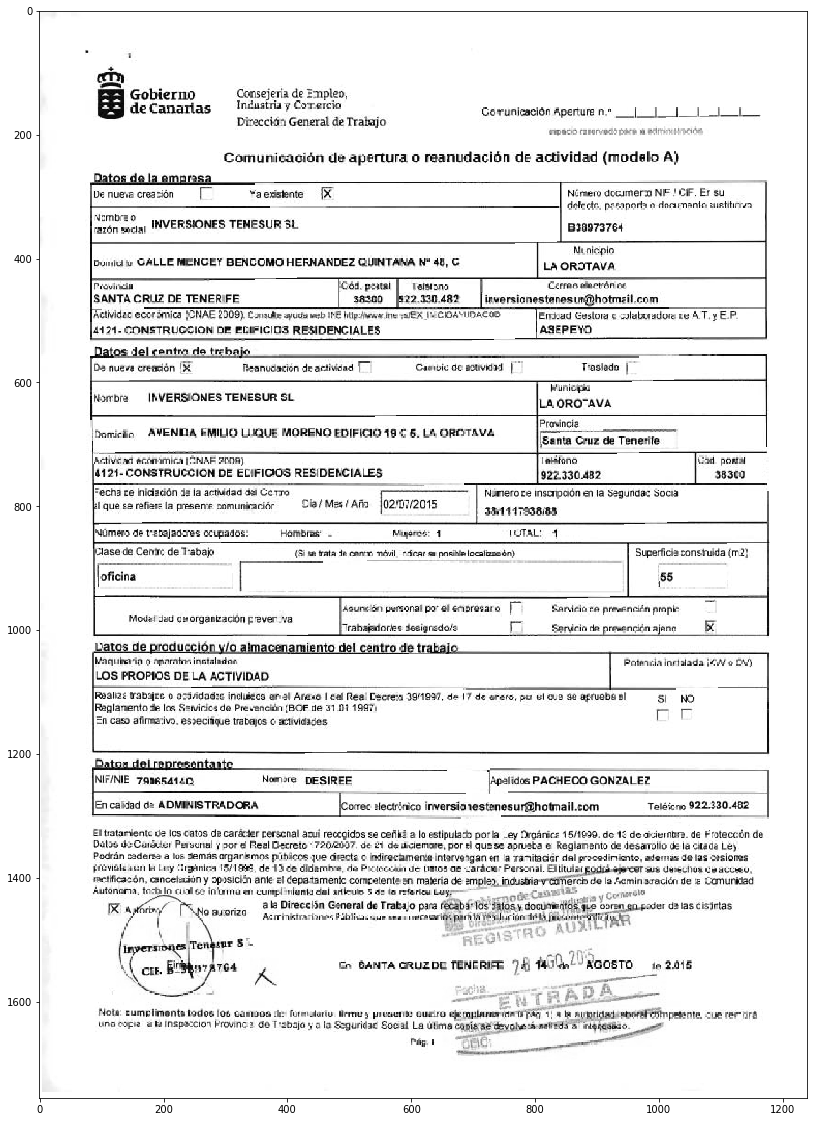

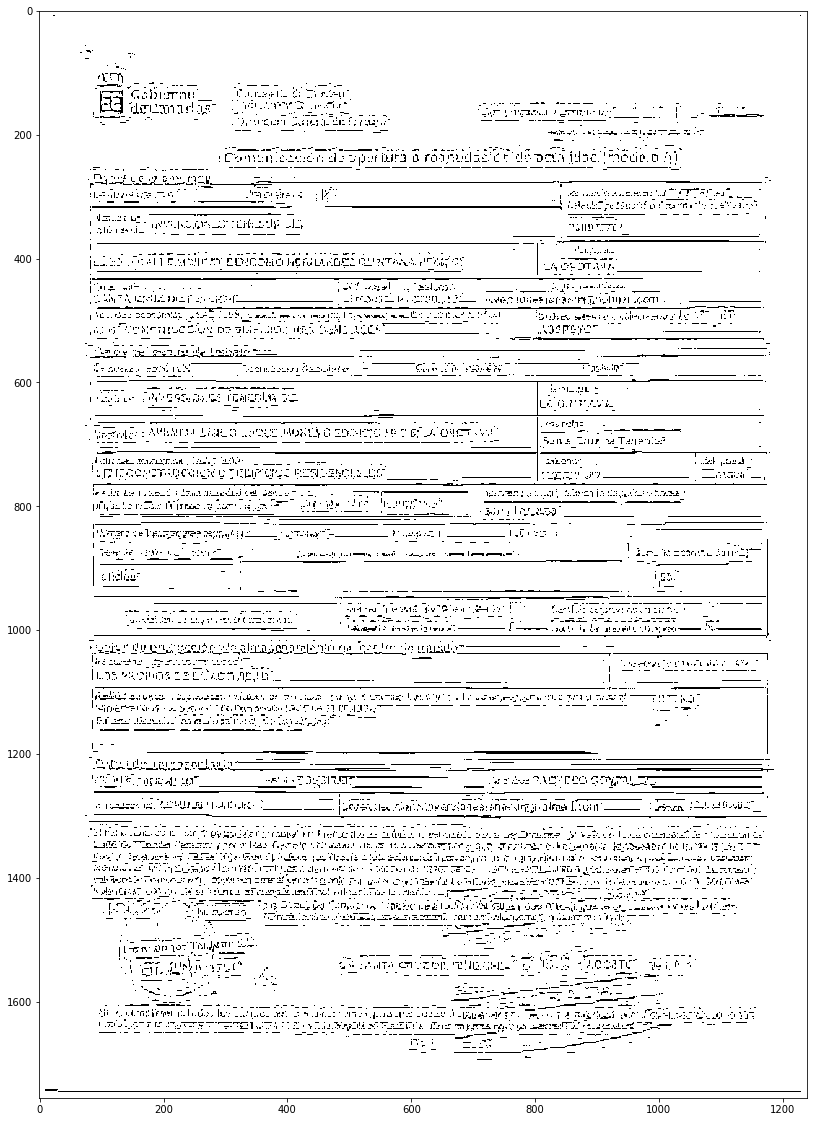

In [14]:
# Let's test our model on a sample test image
sample_test = load_img("data/modeloA_val/test2.png", grayscale=True, target_size=(1756,1240))
sample_test = img_to_array(sample_test)
sample_test_img = sample_test.astype('float32')/255.
sample_test_img = np.expand_dims(sample_test, axis=0)

# Get the predition
predicted_label = np.squeeze(loaded_model.predict(sample_test_img))

plt.figure(figsize=(40,20))
plt.imshow(np.squeeze(sample_test), cmap='gray')
plt.show()
plt.figure(figsize=(40,20))
plt.imshow(np.squeeze(predicted_label.astype('int8')), cmap='gray')
plt.show()

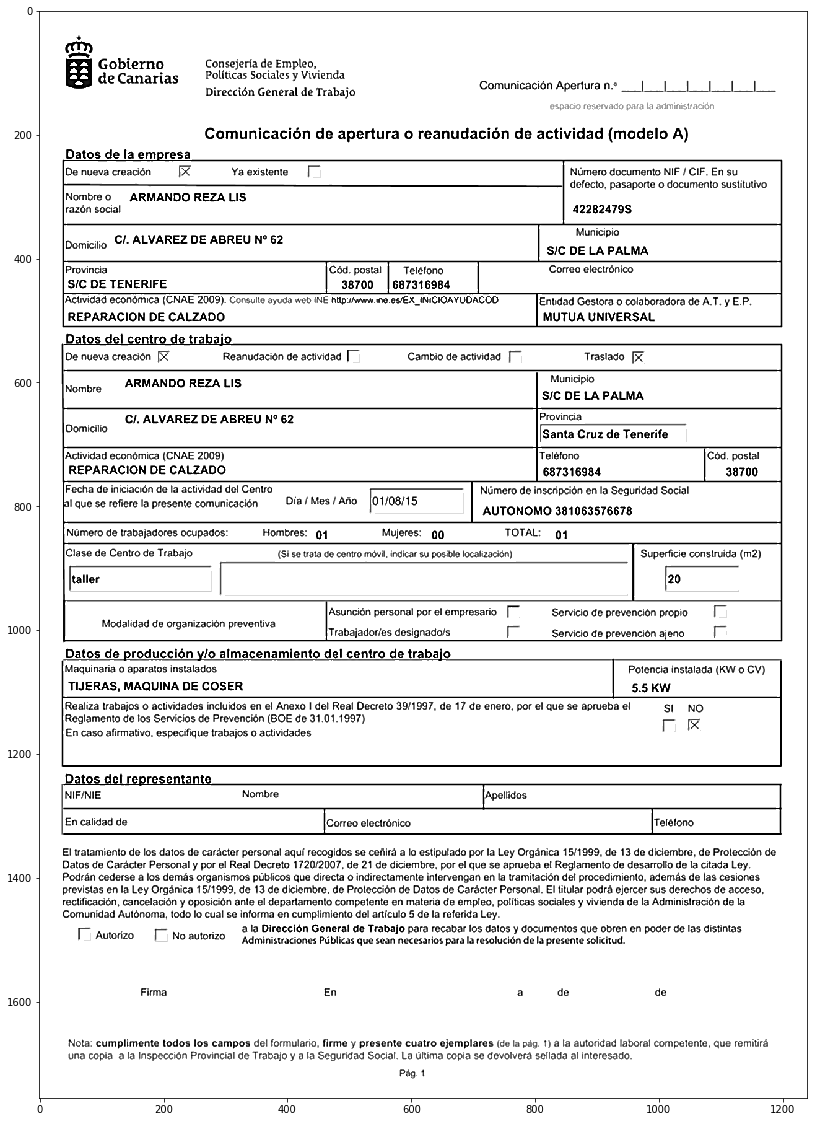

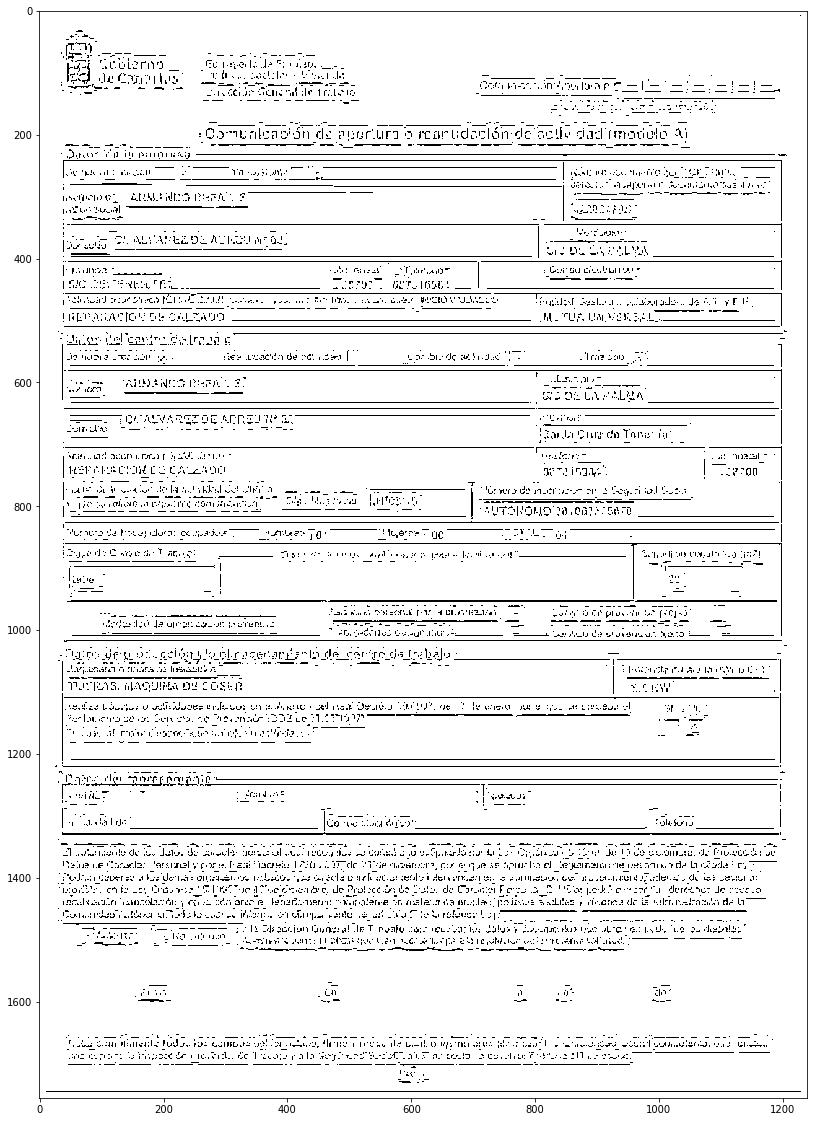

In [13]:
# Let's test our model on a sample test image
sample_test = load_img(str(train/ train_images[10]), grayscale=True, target_size=(1756,1240))
sample_test = img_to_array(sample_test)
sample_test_img = sample_test.astype('float32')/255.
sample_test_img = np.expand_dims(sample_test, axis=0)

# Get the predition
predicted_label = np.squeeze(loaded_model.predict(sample_test_img))

plt.figure(figsize=(20,20))
plt.imshow(np.squeeze(sample_test), cmap='gray')
plt.show()
plt.figure(figsize=(20,20))
plt.imshow(np.squeeze(predicted_label.astype('int8')), cmap='gray')
plt.show()

Mejora con respecto al autoencoder anterior, pero seguimos perdiendo demasiada información.

# 3. Autoencoder granular

Probamos otra idea para tratar de aumentar la cantidad de datos y la calidad de entrenamiento. Dividimos cada imagen en cuadros de subimagenes de tamaño 8x8 pixeles. Idea tomada de:

https://www.kaggle.com/erdoganb/recreating-images-with-autoencoder

Esto hace que aumentamos los datos de entrenamiento

In [33]:
import math
from scipy import misc

train_raw = []
train = []
train_cleaned_raw = []
train_cleaned = []
test = []
img_batch_size = 18
test_ratio = 0.2

# gather all images in cleaned dataset in to the train_raw
files = os.listdir("./data/modeloA_train")
for filename in files:
    if filename.find('.png') > -1:
        img = misc.imread('./data/modeloA_train/' + filename)
        img = load_img("data/modeloA_train/" + filename, grayscale=True, target_size=(1760,1240))
        img = img_to_array(img)
        img = img.astype('float32')/255.
        train_raw.append(img)

img = filename = files = None

# gather all images in cleaned dataset in to the train_raw
files = os.listdir("./data/modeloA_train_cleaned")
for filename in files:
    if filename.find('.png') > -1:
        img = misc.imread('./data/modeloA_train_cleaned/' + filename)
        img = load_img("data/modeloA_train_cleaned/" + filename, grayscale=True, target_size=(1760,1240))
        img = img_to_array(img)
        img = img.astype('float32')/255.
        train_cleaned_raw.append(img)

img = filename = files = None


# iterate images and split them by img_batch_size*img_batch_size pieces, put in to the train var
for img in train_raw:
    d0_batch = math.ceil(img.shape[0] / img_batch_size)
    d1_batch = math.ceil(img.shape[1] / img_batch_size)
    img = img / 255
    for d0_i in range(int(d0_batch)):
        for d1_i in range(int(d1_batch)):
            img_batch = img[d0_i*img_batch_size: (d0_i + 1)*img_batch_size,
                            d1_i*img_batch_size: (d1_i + 1)*img_batch_size]
            if img_batch.size == img_batch_size*img_batch_size:
                train.append(img_batch)
    
img_batch = d0_batch = d1_batch = d0_i = d1_i = None

# iterate images and split them by img_batch_size*img_batch_size pieces, put in to the train var
for img in train_cleaned_raw:
    d0_batch = math.ceil(img.shape[0] / img_batch_size)
    d1_batch = math.ceil(img.shape[1] / img_batch_size)
    img = img / 255
    for d0_i in range(int(d0_batch)):
        for d1_i in range(int(d1_batch)):
            img_batch = img[d0_i*img_batch_size: (d0_i + 1)*img_batch_size,
                            d1_i*img_batch_size: (d1_i + 1)*img_batch_size]
            if img_batch.size == img_batch_size*img_batch_size:
                train_cleaned.append(img_batch)
    
img_batch = d0_batch = d1_batch = d0_i = d1_i = None


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  app.launch_new_instance()
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:28: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


In [34]:
print(len(train),train[0].shape,len(train_cleaned),train_cleaned[0].shape)

(527680, (18, 18, 1), 527680, (18, 18, 1))


In [35]:
from random import shuffle

# shuffle, turn in to a numpy array, split test/train dataset by test_ratio
#shuffle(train)
train = np.array(train)
train_cleaned = np.array(train_cleaned)

test = train[:int(train.shape[0]*test_ratio),:,:]
train = train[int(train.shape[0]*test_ratio):,:,:]
test_cleaned = train_cleaned[:int(train_cleaned.shape[0]*test_ratio),:,:]
train_cleaned = train_cleaned[int(train_cleaned.shape[0]*test_ratio):,:,:]

train = train.reshape((len(train), np.prod(train.shape[1:])))
test = test.reshape((len(test), np.prod(test.shape[1:])))
train_cleaned = train_cleaned.reshape((len(train_cleaned), np.prod(train_cleaned.shape[1:])))
test_cleaned = test_cleaned.reshape((len(test_cleaned), np.prod(test_cleaned.shape[1:])))

In [36]:
print(train.shape,test.shape)

((422144, 324), (105536, 324))


In [37]:
# size of hidden layer of autoencoder
encoding_dim = int(img_batch_size*img_batch_size / 4)
# input placeholder
input_img = Input(shape=(img_batch_size*img_batch_size,))
# hidden layer
encoded = Dense(encoding_dim, activation='relu')(input_img)
# output layer
decoded = Dense(img_batch_size*img_batch_size, activation='sigmoid')(encoded)

# put them in a Model
autoencoder = Model(input_img, decoded)

# compile and train
adam = Adam(lr=0.0001, decay=1e-3)
autoencoder.compile(optimizer=adam, loss='binary_crossentropy')
autoencoder.fit(train, train_cleaned,
                verbose=2,
                epochs=500,
                batch_size=8192,
                validation_data=(test,test_cleaned))
# Uncomment this if you want to observe losses
#print(autoencoder.history.history)

Train on 422144 samples, validate on 105536 samples
Epoch 1/500
9s - loss: 0.6912 - val_loss: 0.6886
Epoch 2/500
9s - loss: 0.6844 - val_loss: 0.6790
Epoch 3/500
9s - loss: 0.6719 - val_loss: 0.6633
Epoch 4/500
9s - loss: 0.6536 - val_loss: 0.6426
Epoch 5/500
10s - loss: 0.6309 - val_loss: 0.6181
Epoch 6/500
10s - loss: 0.6050 - val_loss: 0.5912
Epoch 7/500
11s - loss: 0.5773 - val_loss: 0.5628
Epoch 8/500
9s - loss: 0.5485 - val_loss: 0.5338
Epoch 9/500
9s - loss: 0.5195 - val_loss: 0.5050
Epoch 10/500
9s - loss: 0.4909 - val_loss: 0.4768
Epoch 11/500
9s - loss: 0.4632 - val_loss: 0.4495
Epoch 12/500
9s - loss: 0.4363 - val_loss: 0.4233
Epoch 13/500
9s - loss: 0.4107 - val_loss: 0.3984
Epoch 14/500
9s - loss: 0.3865 - val_loss: 0.3750
Epoch 15/500
9s - loss: 0.3638 - val_loss: 0.3531
Epoch 16/500
10s - loss: 0.3426 - val_loss: 0.3326
Epoch 17/500
9s - loss: 0.3228 - val_loss: 0.3136
Epoch 18/500
9s - loss: 0.3045 - val_loss: 0.2960
Epoch 19/500
9s - loss: 0.2874 - val_loss: 0.2796
Epo

8s - loss: 0.0259 - val_loss: 0.0259
Epoch 164/500
8s - loss: 0.0258 - val_loss: 0.0258
Epoch 165/500
8s - loss: 0.0257 - val_loss: 0.0258
Epoch 166/500
8s - loss: 0.0257 - val_loss: 0.0257
Epoch 167/500
8s - loss: 0.0256 - val_loss: 0.0257
Epoch 168/500
8s - loss: 0.0256 - val_loss: 0.0256
Epoch 169/500
8s - loss: 0.0255 - val_loss: 0.0256
Epoch 170/500
8s - loss: 0.0255 - val_loss: 0.0255
Epoch 171/500
8s - loss: 0.0254 - val_loss: 0.0255
Epoch 172/500
8s - loss: 0.0254 - val_loss: 0.0254
Epoch 173/500
8s - loss: 0.0253 - val_loss: 0.0254
Epoch 174/500
8s - loss: 0.0253 - val_loss: 0.0253
Epoch 175/500
8s - loss: 0.0252 - val_loss: 0.0253
Epoch 176/500
8s - loss: 0.0252 - val_loss: 0.0252
Epoch 177/500
8s - loss: 0.0252 - val_loss: 0.0252
Epoch 178/500
8s - loss: 0.0251 - val_loss: 0.0252
Epoch 179/500
8s - loss: 0.0251 - val_loss: 0.0251
Epoch 180/500
8s - loss: 0.0250 - val_loss: 0.0251
Epoch 181/500
8s - loss: 0.0250 - val_loss: 0.0250
Epoch 182/500
8s - loss: 0.0250 - val_loss: 0

8s - loss: 0.0242 - val_loss: 0.0242
Epoch 325/500
8s - loss: 0.0242 - val_loss: 0.0242
Epoch 326/500
8s - loss: 0.0242 - val_loss: 0.0242
Epoch 327/500
8s - loss: 0.0242 - val_loss: 0.0242
Epoch 328/500
8s - loss: 0.0242 - val_loss: 0.0242
Epoch 329/500
8s - loss: 0.0242 - val_loss: 0.0242
Epoch 330/500
8s - loss: 0.0242 - val_loss: 0.0242
Epoch 331/500
8s - loss: 0.0242 - val_loss: 0.0242
Epoch 332/500
8s - loss: 0.0242 - val_loss: 0.0242
Epoch 333/500
8s - loss: 0.0242 - val_loss: 0.0242
Epoch 334/500
8s - loss: 0.0242 - val_loss: 0.0242
Epoch 335/500
8s - loss: 0.0242 - val_loss: 0.0242
Epoch 336/500
8s - loss: 0.0242 - val_loss: 0.0242
Epoch 337/500
8s - loss: 0.0242 - val_loss: 0.0242
Epoch 338/500
8s - loss: 0.0242 - val_loss: 0.0242
Epoch 339/500
8s - loss: 0.0242 - val_loss: 0.0242
Epoch 340/500
8s - loss: 0.0242 - val_loss: 0.0242
Epoch 341/500
8s - loss: 0.0242 - val_loss: 0.0242
Epoch 342/500
8s - loss: 0.0242 - val_loss: 0.0242
Epoch 343/500
8s - loss: 0.0242 - val_loss: 0

8s - loss: 0.0241 - val_loss: 0.0241
Epoch 486/500
8s - loss: 0.0241 - val_loss: 0.0241
Epoch 487/500
8s - loss: 0.0241 - val_loss: 0.0241
Epoch 488/500
8s - loss: 0.0241 - val_loss: 0.0241
Epoch 489/500
8s - loss: 0.0241 - val_loss: 0.0241
Epoch 490/500
8s - loss: 0.0241 - val_loss: 0.0241
Epoch 491/500
8s - loss: 0.0241 - val_loss: 0.0241
Epoch 492/500
8s - loss: 0.0241 - val_loss: 0.0241
Epoch 493/500
8s - loss: 0.0241 - val_loss: 0.0241
Epoch 494/500
8s - loss: 0.0241 - val_loss: 0.0241
Epoch 495/500
8s - loss: 0.0241 - val_loss: 0.0241
Epoch 496/500
8s - loss: 0.0241 - val_loss: 0.0241
Epoch 497/500
8s - loss: 0.0241 - val_loss: 0.0241
Epoch 498/500
8s - loss: 0.0241 - val_loss: 0.0241
Epoch 499/500
8s - loss: 0.0241 - val_loss: 0.0241
Epoch 500/500
8s - loss: 0.0241 - val_loss: 0.0241


In [38]:
# gather dirty test data
test_dirty_raw = []
files = os.listdir("./data/modeloA_val")
i = 0
for filename in files:
    if (filename.find('.png') > -1 and i < 1):
        #img = misc.imread('./data/modeloA_val/' + filename, grayscale=True, target_size=(1760,1240))
        img = load_img("data/modeloA_val/test2.png", grayscale=True, target_size=(1760,1240))
        img = img_to_array(img)
        img = img.astype('float32')/255.
        #img = np.expand_dims(img, axis=0)

        test_dirty_raw.append(img)

img = filename = files = None

In [39]:
print(train_raw[0].shape,test_dirty_raw[1].shape)

((1760, 1240, 1), (1760, 1240, 1))


(1760, 1240, 1)


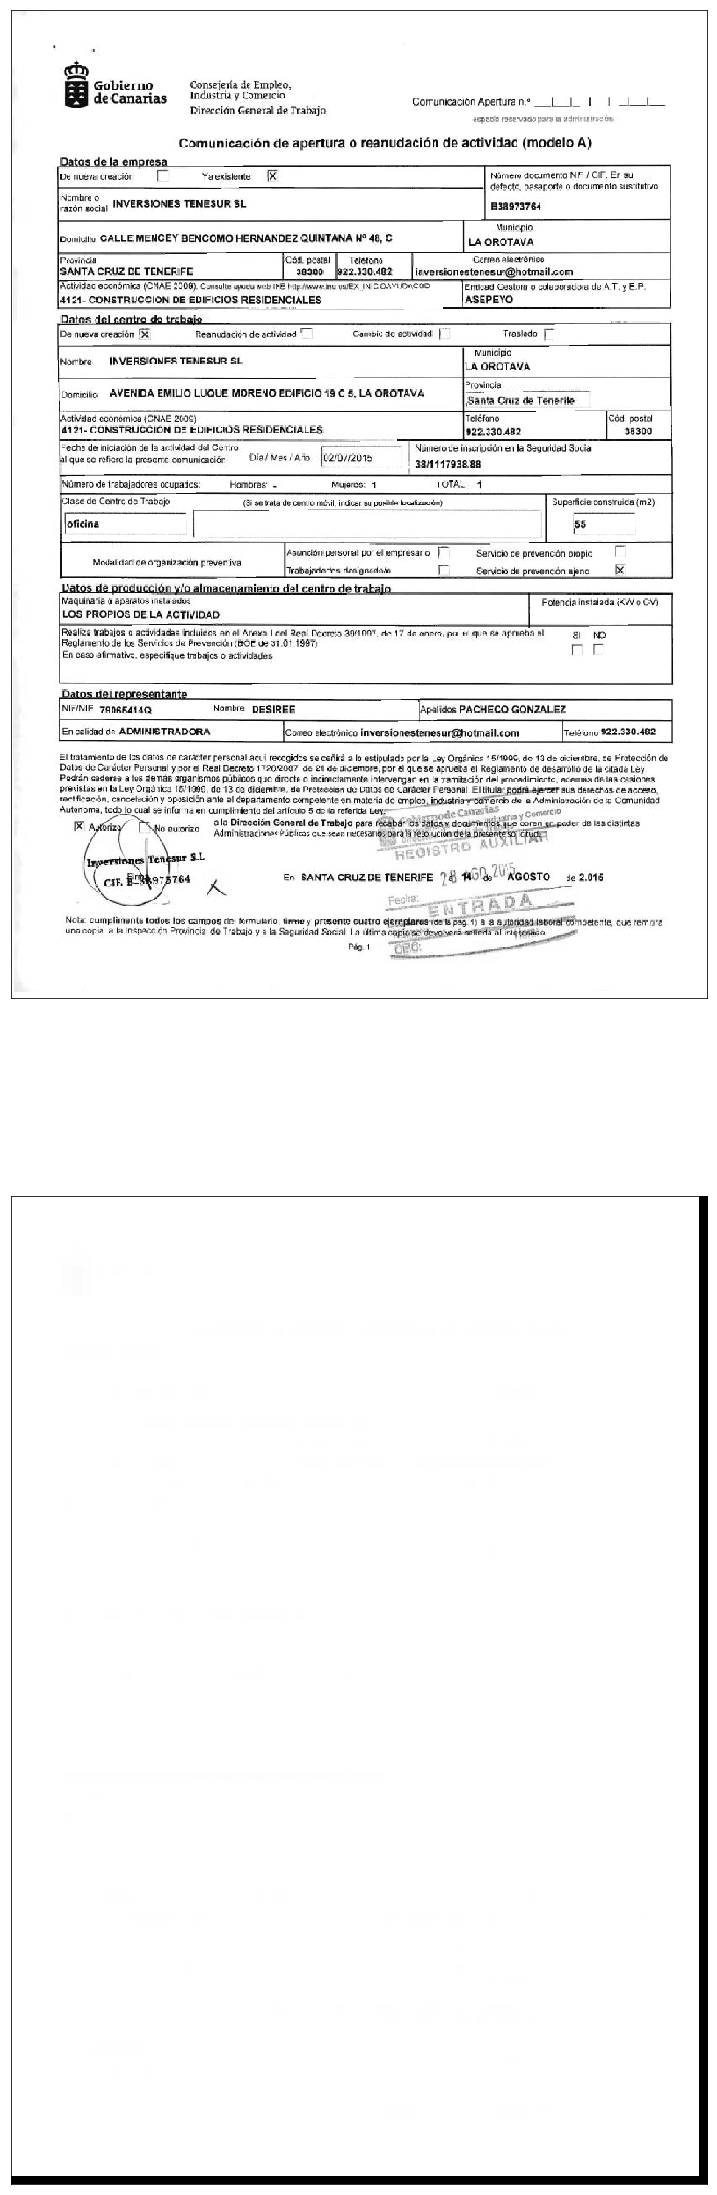

In [41]:
test_img = np.array(test_dirty_raw[np.random.randint(len(test_dirty_raw))]) / 255
print(test_img.shape)
d0_batch = math.ceil(test_img.shape[0] / img_batch_size)
d1_batch = math.ceil(test_img.shape[1] / img_batch_size)

test_img_p = np.ones(test_img.shape)

#
for d0_i in range(int(d0_batch)):
    for d1_i in range(int(d1_batch)):
        img_batch = test_img[d0_i*img_batch_size: (d0_i + 1)*img_batch_size,
                             d1_i*img_batch_size: (d1_i + 1)*img_batch_size]
        if img_batch.size == img_batch_size*img_batch_size:
            img_batch = np.array(img_batch.reshape(1,img_batch.size))

            img_batch_p = autoencoder.predict(img_batch)
            img_batch_p = img_batch_p.reshape((img_batch_size,img_batch_size,1))
            test_img_p[d0_i*img_batch_size: (d0_i + 1)*img_batch_size,
                       d1_i*img_batch_size:(d1_i + 1)*img_batch_size] = img_batch_p

img_batch = d0_batch = d1_batch = d0_i = d1_i = None

# draw test and recreated images
plt.figure(figsize=(40, 40))

ax = plt.subplot(2, 1, 1)
plt.imshow(np.squeeze(test_img * 255), cmap='gray')
#plt.imshow(test_img * 255)
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(2, 1, 2)
plt.imshow(np.squeeze(1-test_img_p * 255), cmap='gray')
#plt.imshow(test_img_p * 255)
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.show()

Al final los autoencoders son una buena idea, mas no hemos podido hacer un entrenamiento que de buenos resultados. 

# 3. BMVC blur Removal

En esta última parte probamos un modelo entrenado para limpieza de documentos desarrollado por investigadores en Republica Checa:

https://github.com/sandeepraju/ihradis-cnn-deblur

Una extensión para imagenes de retratos está también disponible:

https://github.com/axium/CNN-For-End-to-End-Deblurring--Keras

Ubicamos el código y los datos en la carpeta ./BMVC_blurRemoval

El modelo entrenado es un autoencoder compuesto por una red neuronal de CNN muy profunda utilizando la librería Caffe (similar a TensorFlow). Dejaron los modelos y los scripts para utilizarlo a dispocisión, al igual que el paper correspondiente (./Doc/hradis15CNNdeblurring.pdf). Instalamos Caffe, y las dependencias necesarias.

Al utilizarlo en nustros documentos vemos una mejora notable qliminando el ruido borroso tipico de la desfocalización al tomar una foto con nuestro móvil, o bien debido al movimiento durante el scan de documentos. 

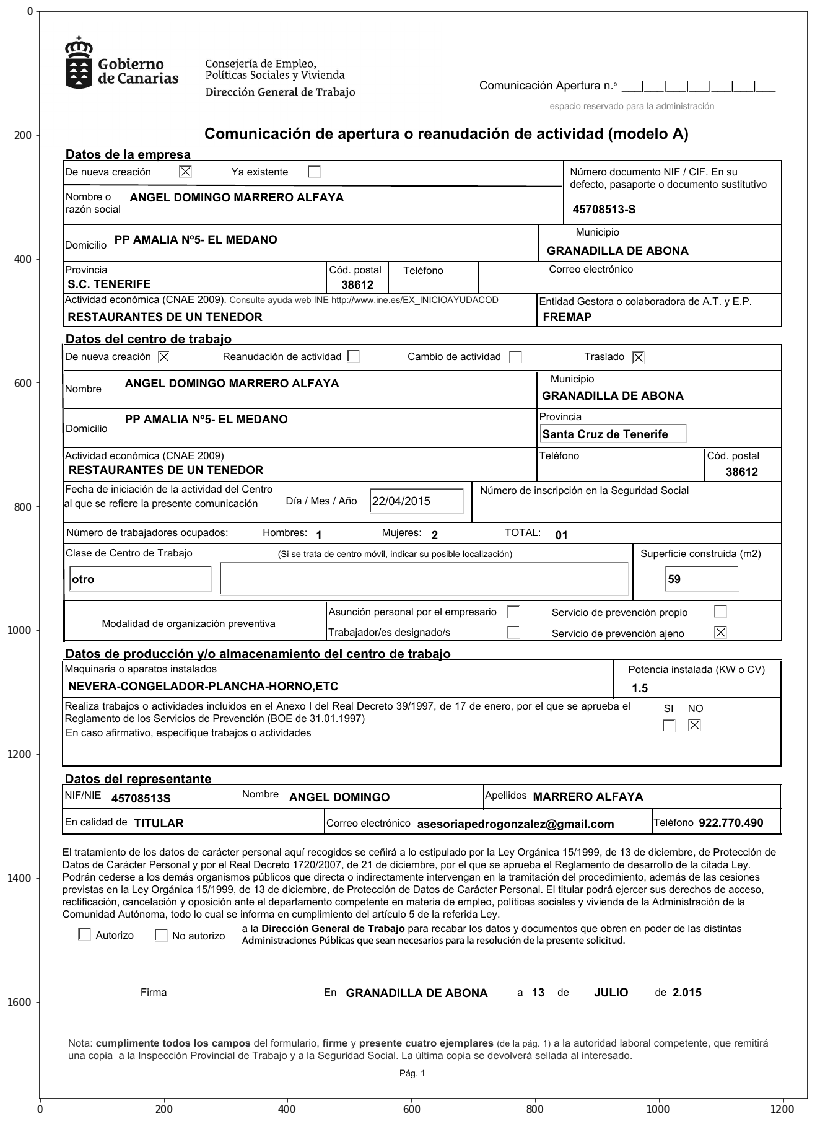

In [17]:
#Original
sample_test = load_img("./BMVC_blurRemoval/original/modeloA_1.png", grayscale=True, target_size=(1756,1240))
sample_test = img_to_array(sample_test)
sample_test_img = sample_test.astype('float32')/255.
sample_test_img = np.expand_dims(sample_test, axis=0)

# Get the preditio
plt.figure(figsize=(40,20))
plt.imshow(np.squeeze(sample_test), cmap='gray')
plt.show()


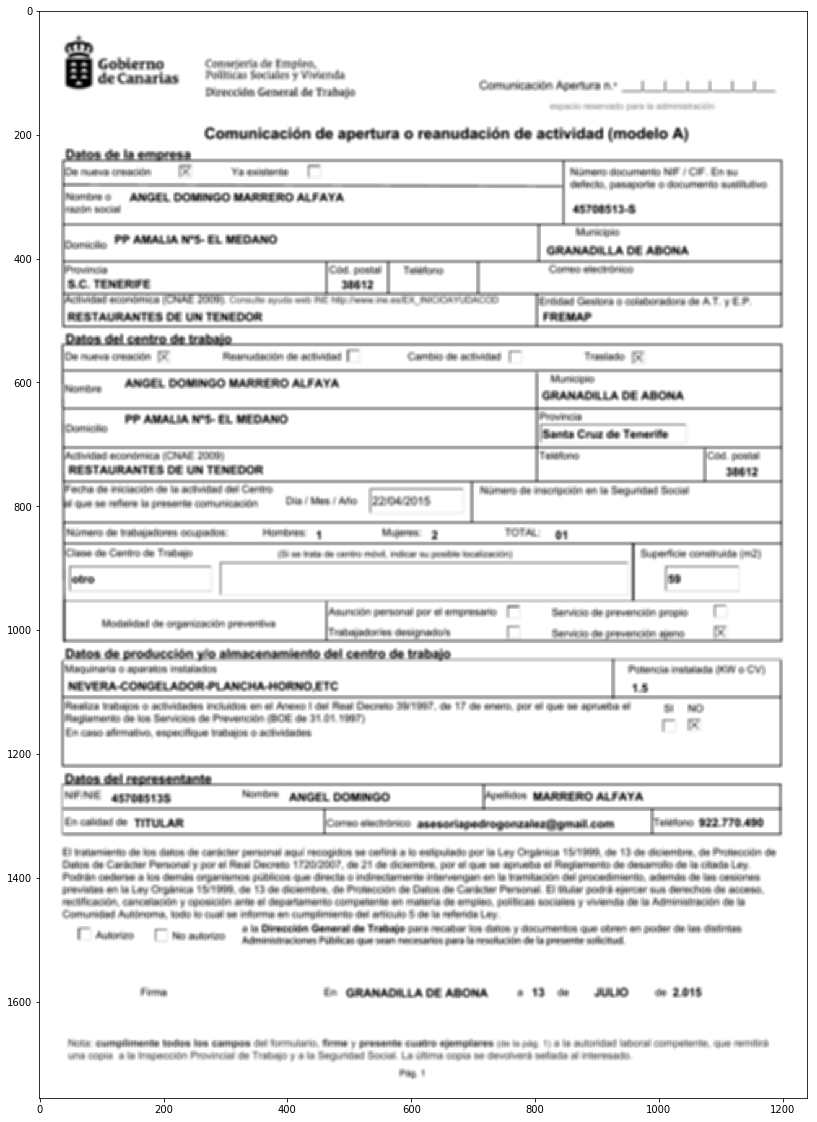

In [18]:
#Blurred
sample_test = load_img("./BMVC_blurRemoval/in/out_modeloA_blur3x3_1.png", grayscale=True, target_size=(1756,1240))
sample_test = img_to_array(sample_test)
sample_test_img = sample_test.astype('float32')/255.
sample_test_img = np.expand_dims(sample_test, axis=0)

# Get the preditio
plt.figure(figsize=(40,20))
plt.imshow(np.squeeze(sample_test), cmap='gray')
plt.show()


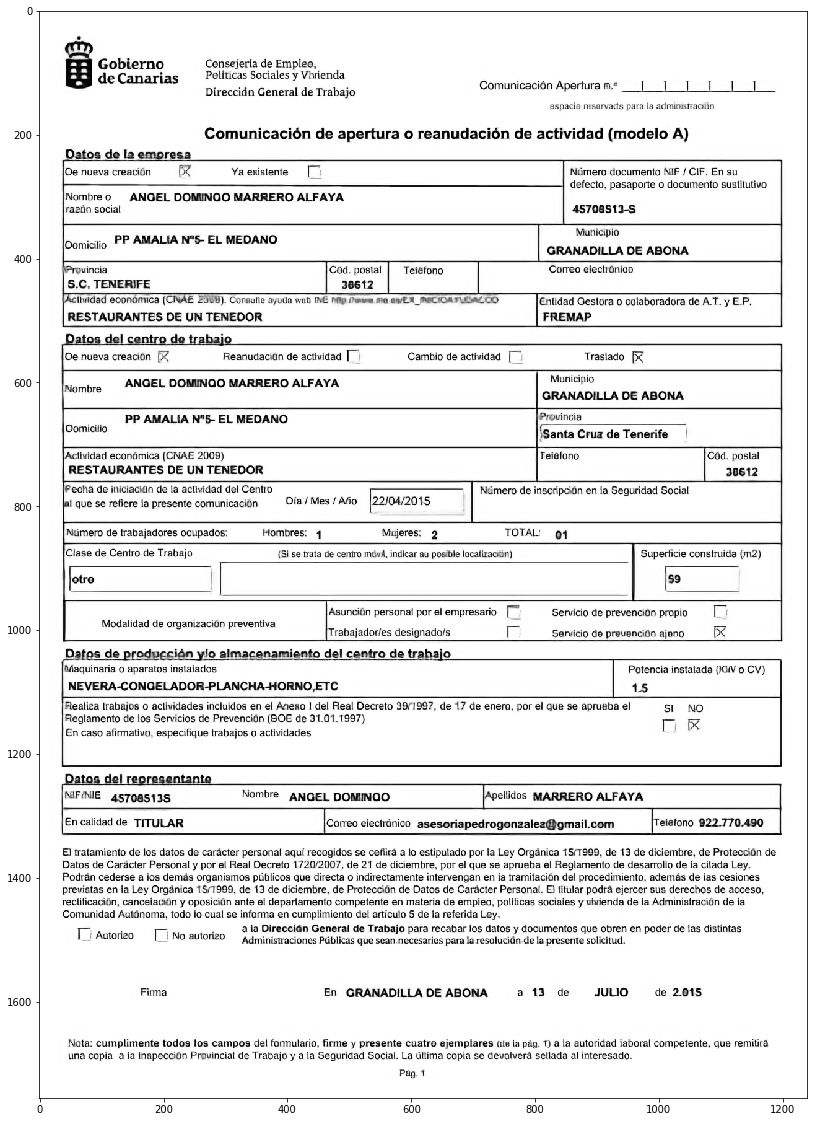

In [19]:
#Out
sample_test = load_img("./BMVC_blurRemoval/out/out_modeloA_blur3x3_1.png_out.png", grayscale=True, target_size=(1756,1240))
sample_test = img_to_array(sample_test)
sample_test_img = sample_test.astype('float32')/255.
sample_test_img = np.expand_dims(sample_test, axis=0)

# Get the preditio
plt.figure(figsize=(40,20))
plt.imshow(np.squeeze(sample_test), cmap='gray')
plt.show()


Vemos una mejora notable y una recuperación de la información de las imagenes borrosas.